In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from statsmodels.tsa.stattools import acf, acovf, pacf, pacf_ols, pacf_yw

In [4]:
from pandas.plotting import lag_plot ## Useful for plotting time-series against lag of its own series

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [7]:
##pip install pmdarima 

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from fbprophet import Prophet

In [10]:
from pmdarima import auto_arima

In [11]:
train = pd.read_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\Train.csv',index_col='Datetime', parse_dates=True, infer_datetime_format=True)


In [64]:
test = pd.read_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\Test.csv',index_col='Datetime', parse_dates=True, infer_datetime_format=True)

In [13]:
submission = pd.read_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\sample_submission.csv')

In [14]:
train

,ID,Count
Datetime,,
2012-08-25 00:00:00,0,8
2012-08-25 01:00:00,1,2
2012-08-25 02:00:00,2,6
2012-08-25 03:00:00,3,2
2012-08-25 04:00:00,4,2
...,...,...
2014-09-25 19:00:00,18283,868
2014-09-25 20:00:00,18284,732
2014-09-25 21:00:00,18285,702


In [15]:
test

,ID
Datetime,
2014-09-26 00:00:00,18288
2014-09-26 01:00:00,18289
2014-09-26 02:00:00,18290
2014-09-26 03:00:00,18291
2014-09-26 04:00:00,18292
...,...
2015-04-26 19:00:00,23395
2015-04-26 20:00:00,23396
2015-04-26 21:00:00,23397


In [17]:
print(train.index.inferred_freq)

H


In [18]:
train[train['Count'].isna()]

,ID,Count
Datetime,,


In [19]:
train[train.duplicated()]

,ID,Count
Datetime,,


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

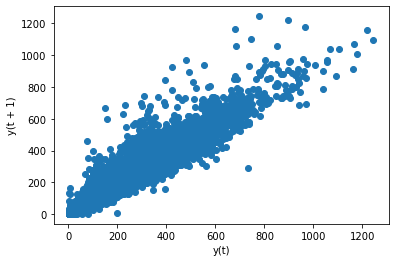

In [20]:
lag_plot(train['Count'])

<AxesSubplot:xlabel='Datetime'>

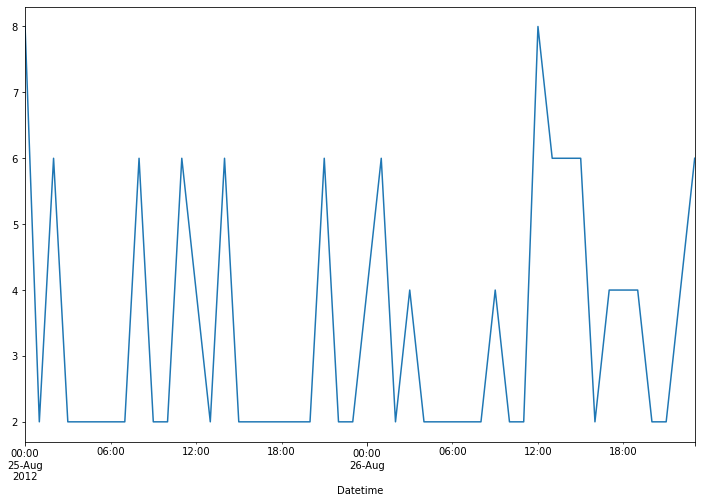

In [21]:
train['Count'][:48].plot(figsize=(12,8))

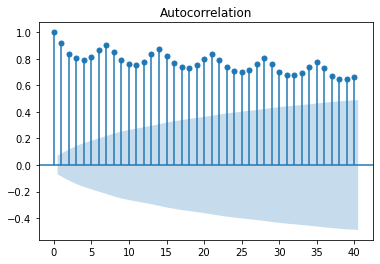

In [35]:
plot_acf(train['Count'], lags=40);

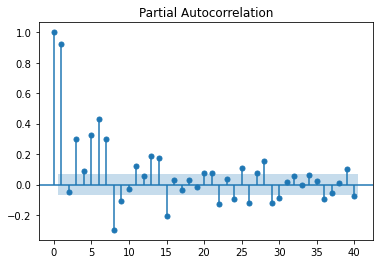

In [36]:
plot_pacf(train['Count'], lags=40);

In [28]:
 train_resample = pd.DataFrame(train['Count'].resample('D').sum())

In [29]:
train_resample

,Count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60
...,...
2014-09-21,9102
2014-09-22,14116
2014-09-23,13304


In [30]:
train_resample.dtypes

Count    int64
dtype: object

In [31]:
train = train_resample.copy()

In [37]:
train

,Count
Datetime,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60
...,...
2014-09-21,9102
2014-09-22,14116
2014-09-23,13304


In [32]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=' '):    #Pass Series and a title, Function returns an ADF Report
    
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') #Dropna() handles differenced data
    ##print(result)
    
    labels = ['ADF test statistic', 'p-value', '# lags used', '# observations']
    out = pd.Series(result[0:4], index=labels)
    
    for key, val in result[4].items():
        out[f'critical value ({key})']= val
    
    print(out.to_string())  # to_string() removes the line "dtype: float"
    
    if result[1] <= 0.5:
        print("Strong evidence against null hypothesis")
        print('Reject the Null Hypothesis')
        print('Data has no unit root and is Stationary')
    else:
        print("Weak evidence against null hypothesis")
        print('Failed to reject the Null Hypothesis')
        print('Data has unit root and is non-Stationary')
    ##return result

In [33]:
adf_test(train['Count'], 'Daily  Passengers')

Augmented Dickey-Fuller Test: Daily  Passengers
ADF test statistic        2.986351
p-value                   1.000000
# lags used              20.000000
# observations          741.000000
critical value (1%)      -3.439206
critical value (5%)      -2.865448
critical value (10%)     -2.568851
Weak evidence against null hypothesis
Failed to reject the Null Hypothesis
Data has unit root and is non-Stationary


In [38]:
from statsmodels.tsa.statespace.tools import diff

In [39]:
train['diff1'] = diff(train['Count'],k_diff=1)

In [40]:
train

,Count,diff1
Datetime,,
2012-08-25,76,NaN
2012-08-26,88,12.0
2012-08-27,62,-26.0
2012-08-28,58,-4.0
2012-08-29,60,2.0
...,...,...
2014-09-21,9102,916.0
2014-09-22,14116,5014.0
2014-09-23,13304,-812.0


In [41]:
adf_test(train['diff1'],'DF Test on differenced data')

Augmented Dickey-Fuller Test: DF Test on differenced data
ADF test statistic     -7.964456e+00
p-value                 2.889911e-12
# lags used             2.000000e+01
# observations          7.400000e+02
critical value (1%)    -3.439218e+00
critical value (5%)    -2.865454e+00
critical value (10%)   -2.568854e+00
Strong evidence against null hypothesis
Reject the Null Hypothesis
Data has no unit root and is Stationary


In [45]:
auto_arima(train['diff1'].dropna(),start_p=0, start_q=0, d=None, max_p=2, max_q=2, max_d=2, seasonal=True,trace=1,m=30)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[30] intercept   : AIC=12948.545, Time=2.47 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=13015.501, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=12956.167, Time=3.58 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=12938.728, Time=2.35 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=13013.668, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=13016.582, Time=0.05 sec
 ARIMA(0,0,1)(1,0,1)[30] intercept   : AIC=12940.410, Time=3.35 sec
 ARIMA(0,0,1)(0,0,2)[30] intercept   : AIC=12939.977, Time=13.92 sec
 ARIMA(0,0,1)(1,0,0)[30] intercept   : AIC=12958.062, Time=26.64 sec
 ARIMA(0,0,1)(1,0,2)[30] intercept   : AIC=inf, Time=28.75 sec
 ARIMA(0,0,0)(0,0,1)[30] intercept   : AIC=12946.566, Time=1.60 sec
 ARIMA(1,0,1)(0,0,1)[30] intercept   : AIC=12758.261, Time=4.39 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=12814.220, Time=0.56 sec
 ARIMA(1,0,1)(1,0,1)[30] intercept   : AIC=12759.929, Time=5.63 sec
 ARIMA(1

ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(0, 0, 1, 30),
      suppress_warnings=True)

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

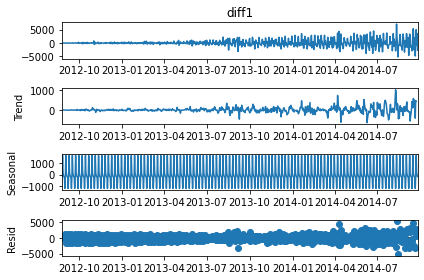

In [50]:
result = seasonal_decompose(train['diff1'].dropna(),model='add')
result.plot();

In [51]:
import  statsmodels.api as sm

In [52]:
model = sm.tsa.statespace.SARIMAX(train['Count'],order=(2,0,1),seasonal_order=(2,0,1,30))

In [53]:
results = model.fit()

In [54]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Count   No. Observations:                  762
Model:             SARIMAX(2, 0, 1)x(2, 0, 1, 30)   Log Likelihood               -6471.022
Date:                            Sat, 18 Sep 2021   AIC                          12956.044
Time:                                    00:25:14   BIC                          12988.496
Sample:                                08-25-2012   HQIC                         12968.539
                                     - 09-25-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1573      0.048      3.290      0.001       0.064       0.251
ar.L2          0.8150      0.050     16.266      0.000       0.717       0.913
ma.L1          0.9067      0.037     24.516      0.000       0.834       0.979
ar.S.L30      -0.2916      0.399     -0.731      0.465      -1.073       0.490
ar.S.L60      -0.1063      0.119     -0.892      0.372      -0.340       0.127
ma.S.L30      -0.0190      0.398     -0.048      0.962      -0.800       0.762
sigma2      1.392e+06   4.37e+04     31.871      0.000    1.31e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                  12.58   Jarque-Bera (JB):               491.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              74.24   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
start = len(train)

In [66]:
end = len(train) + len(test) - 1

In [67]:
print(start, end)

762 5873


In [68]:
predictions = results.predict(start=start, end=end,typ='levels')

In [69]:
predictions.dtypes

dtype('float64')

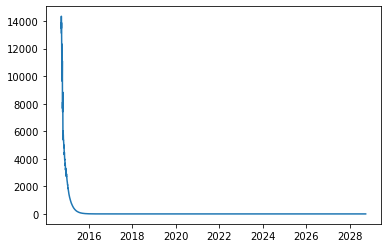

In [75]:
plt.plot(predictions)

In [70]:
arima_results = pd.concat([test, predictions], axis=1)

In [71]:
arima_results.columns = ['ID', 'Count']

In [72]:
arima_results

,ID,Count
2014-09-26 00:00:00,18288.0,1.314711e+04
2014-09-26 01:00:00,18289.0,NaN
2014-09-26 02:00:00,18290.0,NaN
2014-09-26 03:00:00,18291.0,NaN
2014-09-26 04:00:00,18292.0,NaN
...,...,...
2028-09-19 00:00:00,NaN,1.725047e-30
2028-09-20 00:00:00,NaN,1.698978e-30
2028-09-21 00:00:00,NaN,1.673303e-30
2028-09-22 00:00:00,NaN,1.648016e-30


In [63]:
arima_results 

,ID,Count
2014-09-26 00:00:00,18288.0,1.314711e+04
2014-09-26 01:00:00,18289.0,NaN
2014-09-26 02:00:00,18290.0,NaN
2014-09-26 03:00:00,18291.0,NaN
2014-09-26 04:00:00,18292.0,NaN
...,...,...
2028-09-19 00:00:00,NaN,1.725047e-30
2028-09-20 00:00:00,NaN,1.698978e-30
2028-09-21 00:00:00,NaN,1.673303e-30
2028-09-22 00:00:00,NaN,1.648016e-30


In [126]:
arima_results.to_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\samplesub.csv', index=False)

In [34]:
# Stationary Dataset
auto_arima(train['Count'], seasonal=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  762
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -6201.322
Date:                Fri, 17 Sep 2021   AIC                          12418.644
Time:                        23:55:23   BIC                          12455.721
Sample:                             0   HQIC                         12432.921
                                - 762                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5590      0.030     18.433      0.000       0.500       0.618
ar.L2         -0.8569      0.026    -32.759      0.000      -0.908      -0.806
ar.L3         -0.0219      0.034     -0.642      0.521      -0.089       0.045
ar.L4         -0.4263      0.024    -17.742      0.000      -0.473      -0.379
ar.L5         -0.2262      0.030     -7.612      0.000      -0.284      -0.168
ma.L1         -1.0996      0.024    -45.551      0.000      -1.147      -1.052
ma.L2          0.8303      0.021     39.740      0.000       0.789       0.871
sigma2      7.098e+05   1.94e+04     36.517      0.000    6.72e+05    7.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              1684.98
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):              57.85   Skew:                             1.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

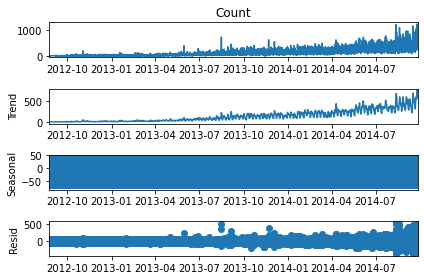

In [57]:
result = seasonal_decompose(train['Count'],model='add')
result.plot();

In [58]:
auto_arima(train['Count'],seasonal=False,trace=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=187702.293, Time=5.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187752.233, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=187738.425, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=187739.699, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=187750.242, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=187703.352, Time=4.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=187702.880, Time=4.29 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=187706.868, Time=6.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=187706.097, Time=17.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=187726.148, Time=3.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=21.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=187704.709, Time=6.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=32.71 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=187700.300, Time=2.57 sec
 ARIMA(1,1,2)(0,

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [59]:
model = ARIMA(train['Count'],order=(2,1,2))

In [60]:
results = model.fit()

In [61]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Count   No. Observations:                18287
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -92792.168
Method:                       css-mle   S.D. of innovations             38.676
Date:                Fri, 17 Sep 2021   AIC                         185596.335
Time:                        21:24:46   BIC                         185643.219
Sample:                    08-25-2012   HQIC                        185611.741
                         - 09-25-2014                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0264      0.125      0.211      0.833      -0.219       0.272
ar.L1.D.Count     1.8657      0.004    476.446      0.000       1.858       1.873
ar.L2.D.Count    -0.9249      0.004   -236.454      0.000      -0.933      -0.917
ma.L1.D.Count    -1.8951      0.004   -513.913      0.000      -1.902      -1.888
ma.L2.D.Count     0.9210      0.004    242.437      0.000       0.914       0.928
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0086           -0.2528j            1.0398           -0.0391
AR.2            1.0086           +0.2528j            1.0398            0.0391
MA.1            1.0288           -0.1652j            1.0420           -0.0253
MA.2            1.0288           +0.1652j            1.0420            0.0253
-----------------------------------------------------------------------------
"""

In [62]:
start = len(train)

In [63]:
end = len(train) + len(test) - 1

In [64]:
print(start, end)

18288 23399


In [90]:
predictions = results.predict(start=start, end=end,typ='levels')

In [112]:
predictions.dtypes

dtype('float64')

In [122]:
arima_results = pd.concat([test, predictions], axis=1)

In [123]:
arima_results.columns = ['ID', 'Count']

In [124]:
arima_results

,ID,Count
2014-09-26 00:00:00,18288,505.612625
2014-09-26 01:00:00,18289,478.294743
2014-09-26 02:00:00,18290,453.584279
2014-09-26 03:00:00,18291,432.749281
2014-09-26 04:00:00,18292,416.733158
...,...,...
2015-04-26 19:00:00,23395,622.269273
2015-04-26 20:00:00,23396,622.295641
2015-04-26 21:00:00,23397,622.322009
2015-04-26 22:00:00,23398,622.348377


In [125]:
arima_results 

,ID,Count
2014-09-26 00:00:00,18288,505.612625
2014-09-26 01:00:00,18289,478.294743
2014-09-26 02:00:00,18290,453.584279
2014-09-26 03:00:00,18291,432.749281
2014-09-26 04:00:00,18292,416.733158
...,...,...
2015-04-26 19:00:00,23395,622.269273
2015-04-26 20:00:00,23396,622.295641
2015-04-26 21:00:00,23397,622.322009
2015-04-26 22:00:00,23398,622.348377


In [126]:
arima_results.to_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\samplesub.csv', index=False)

In [130]:
trainfb = pd.read_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\Train.csv', parse_dates=True, infer_datetime_format=True)


In [215]:
testfb = pd.read_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\Test.csv', index_col='ID', parse_dates=True, infer_datetime_format=True)

In [133]:
train = trainfb[['Datetime', 'Count']]

In [135]:
train.columns = ['ds', 'y']

In [136]:
train

,ds,y
0,25-08-2012 00:00,8
1,25-08-2012 01:00,2
2,25-08-2012 02:00,6
3,25-08-2012 03:00,2
4,25-08-2012 04:00,2
...,...,...
18283,25-09-2014 19:00,868
18284,25-09-2014 20:00,732
18285,25-09-2014 21:00,702
18286,25-09-2014 22:00,580


<AxesSubplot:>

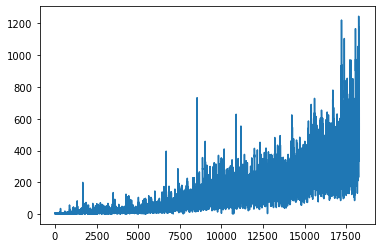

In [137]:
train['y'].plot()

In [161]:
m = Prophet(interval_width=0.95, daily_seasonality=False)

In [162]:
model = m.fit(train)

In [163]:
future = model.make_future_dataframe(periods=10, freq='H')

In [165]:
future.head(15)

,ds
0,2012-01-09 00:00:00
1,2012-01-09 01:00:00
2,2012-01-09 02:00:00
3,2012-01-09 03:00:00
4,2012-01-09 04:00:00
5,2012-01-09 05:00:00
6,2012-01-09 06:00:00
7,2012-01-09 07:00:00
8,2012-01-09 08:00:00
9,2012-01-09 09:00:00


In [146]:
forecast = model.predict(future)

In [147]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-09 00:00:00,30.756527,-143.818405,189.584499,30.756527,30.756527,-8.735176,-8.735176,-8.735176,5.293235,...,-14.611040,-14.611040,-14.611040,0.582629,0.582629,0.582629,0.0,0.0,0.0,22.021351
1,2012-01-09 01:00:00,30.747011,-179.077776,167.844780,30.747011,30.747011,-29.508039,-29.508039,-29.508039,-17.183663,...,-12.867891,-12.867891,-12.867891,0.543514,0.543514,0.543514,0.0,0.0,0.0,1.238971
2,2012-01-09 02:00:00,30.737494,-196.977160,146.352587,30.737494,30.737494,-50.375279,-50.375279,-50.375279,-39.784233,...,-11.094997,-11.094997,-11.094997,0.503951,0.503951,0.503951,0.0,0.0,0.0,-19.637785
3,2012-01-09 03:00:00,30.727978,-195.104146,143.466210,30.727978,30.727978,-66.138004,-66.138004,-66.138004,-57.301307,...,-9.300637,-9.300637,-9.300637,0.463940,0.463940,0.463940,0.0,0.0,0.0,-35.410027
4,2012-01-09 04:00:00,30.718461,-208.068584,137.287343,30.718461,30.718461,-75.457143,-75.457143,-75.457143,-68.387413,...,-7.493215,-7.493215,-7.493215,0.423485,0.423485,0.423485,0.0,0.0,0.0,-44.738682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23395,2015-07-10 19:00:00,459.257089,290.260752,729.004579,323.073164,593.078024,49.307455,49.307455,49.307455,38.815497,...,-2.605565,-2.605565,-2.605565,13.097522,13.097522,13.097522,0.0,0.0,0.0,508.564544
23396,2015-07-10 20:00:00,459.275238,295.981755,730.655885,323.046859,593.131231,45.004809,45.004809,45.004809,35.582136,...,-3.651189,-3.651189,-3.651189,13.073862,13.073862,13.073862,0.0,0.0,0.0,504.280048
23397,2015-07-10 21:00:00,459.293388,289.405907,726.103184,323.020554,593.184438,41.440812,41.440812,41.440812,33.116070,...,-4.725205,-4.725205,-4.725205,13.049946,13.049946,13.049946,0.0,0.0,0.0,500.734199
23398,2015-07-10 22:00:00,459.311537,273.723025,718.783742,322.994249,593.237644,37.205733,37.205733,37.205733,30.005788,...,-5.825832,-5.825832,-5.825832,13.025777,13.025777,13.025777,0.0,0.0,0.0,496.517270


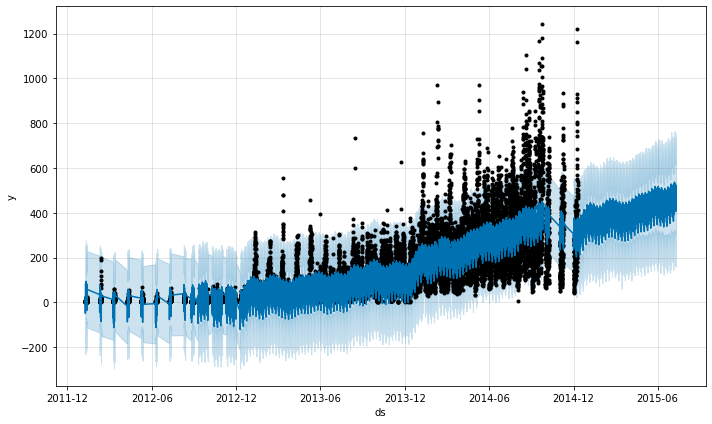

In [260]:
m.plot(forecast);

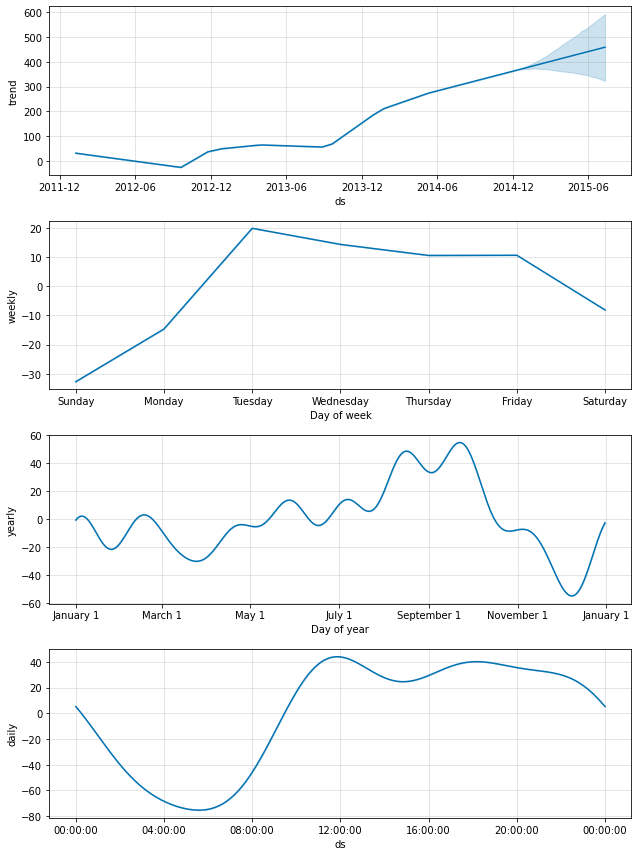

In [149]:
m.plot_components(forecast);

In [190]:
fc = pd.DataFrame(forecast['yhat'][18288:])

In [208]:
fc.columns = ['Count']

In [214]:
fc

,Count
18288,331.521177
18289,308.561216
18290,285.499834
18291,267.547795
18292,256.055745
...,...
23395,508.564544
23396,504.280048
23397,500.734199
23398,496.517270


In [216]:
testfb

,Datetime
ID,
18288,26-09-2014 00:00
18289,26-09-2014 01:00
18290,26-09-2014 02:00
18291,26-09-2014 03:00
18292,26-09-2014 04:00
...,...
23395,26-04-2015 19:00
23396,26-04-2015 20:00
23397,26-04-2015 21:00


In [218]:
fbresults = pd.concat([testfb, fc],axis=1)

In [220]:
fbresults.reset_index(level=0, inplace=True)

In [223]:
fbresults1 = fbresults[['index', 'Count']]

In [225]:
fbresults1.columns = ['ID', 'Count']

In [227]:
fbresults1.to_csv(r'C:\Users\mailk\OneDrive\Desktop\AI and ML\Time Series\data\Hackathon\fbresults.csv', index=False)